**Student ID: u6579712** 

**Student Name: Jieli Zheng**

**Task-1: Harris Corner Detector**
--

CLAB Task-1: Harris Corner Detector <br>
Your name (Your uniID): Jieli Zheng (u6579712)

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def conv2(img, conv_filter):
    # flip the filter
    f_siz_1, f_size_2 = conv_filter.shape
    conv_filter = conv_filter[range(f_siz_1 - 1, -1, -1), :][:, range(f_siz_1 - 1, -1, -1)]
    pad = (conv_filter.shape[0] - 1) // 2
    result = np.zeros((img.shape))

    # NOTICE I change the padding method to symmetric!
    img = np.pad(img,((pad, pad), (pad, pad)), 'symmetric')
    filter_size = conv_filter.shape[0]
    for r in np.arange(img.shape[0] - filter_size + 1):
        for c in np.arange(img.shape[1] - filter_size + 1):
            curr_region = img[r:r + filter_size, c:c + filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)  # Summing the result of multiplication.
            result[r, c] = conv_sum  # Saving the summation in the convolution layer feature map.

    return result

In [3]:
def fspecial(shape=(3, 3), sigma=0.5):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [4]:
# Parameters, add more if needed
sigma = 4
thresh = 0.01

k=0.01

nms_size = 11

In [5]:
# Derivative masks
dx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
dy = dx.transpose()

# load pictures
pics = []
gray_pics = []
for i in range(4):
    bw_origin = cv2.imread(f"Harris_{i+1}.jpg")
    bw_origin = cv2.cvtColor(bw_origin,cv2.COLOR_BGR2RGB)
    pics.append(bw_origin)
    bw_origin = cv2.cvtColor(bw_origin,cv2.COLOR_RGB2GRAY)
    gray_pics.append(bw_origin)
bw_original = pics[0]
bw = gray_pics[0]

# bw = np.array(bw * 255, dtype=int)

# computer x and y derivatives of image
Ix = conv2(bw, dx)
Iy = conv2(bw, dy)

######################################################################
# Task 1.3
######################################################################
# We got a 2D np.floor(3 * sigma) * 2 + 1)*np.floor(3 * sigma) * 2 + 1) Gaussian filter with sigma = sigma, mean = 0 
g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)

Iy2 = conv2(np.power(Iy, 2), g)
Ix2 = conv2(np.power(Ix, 2), g)
Ixy = conv2(Ix * Iy, g)

In [6]:
######################################################################
# Task1.2 & Task 1.3: Compute the Harris Cornerness
######################################################################
def harris_corner(bw, Ix2, Iy2, Ixy, k=0.01):
    """
    harris corner detect algorithm w/o nms operations and thresholding.
    second order derivatives along x and y axis are expected.
    :param bw: the original grayscale image.
    :param Ix2: the second order derivative of the image w.r.t x axis.
    :param Iy2: the second order derivative of the image w.r.t y axis.
    :param Ixy: the second order derivative of the image w.r.t both x and y
    :param k: the empirical constant for MCR. default 0.01
    :return: measure of corner response for all pixels in the image.
    """
    # measure of corner response
    R = np.zeros(bw.shape)
    # loop through all pixels
    for i, row in enumerate(bw):
        for j, pixel in enumerate(row):
            # M =[[Ix^2, Ixy] , [Ixy, Iy^2]], and its determinant and trace are shown below:
            current_determinant = Ix2[i][j]*Iy2[i][j]-2*Ixy[i][j]
            current_trace = Ix2[i][j] + Iy2[i][j]
            # measure of corner response = det(M) - k(trace(M))^2
            current_MCR = current_determinant - k*np.power(current_trace,2)
            #  store measure of corner response in matrix R
            # print(current_MCR.shape)
#             if i!=1 and i!=bw.shape[0] and j!=1 and j!=bw.shape[1]:
            R[i][j] = current_MCR

    return R

In [7]:
R = harris_corner(bw, Ix2, Iy2, Ixy,k=k)

In [8]:
######################################################################
# Task: Perform non-maximum suppression and
#       thresholding, return the N corner points
#       as an Nx2 matrix of x and y coordinates
######################################################################
def nms_thresholding(R, nms_size=3, d=0.01):
    """
    Non-maximum Suppression a.w.a thresholding for MCR
    :param R: measure of corner response for a certain image.
    :param nms_size: decide how large the nms window is. odd number is expected.
    :param d: thresholding. default 0.01
    :return: the result map of the image.
    """
    # the result map of the image
    ans = []
    # shift from centre pixel.
    shift = int((nms_size-1)/2)
    threshold = d*np.max(R)
#     print(threshold)
    for i, row in enumerate(R):
        for j, mcr in enumerate(row):
            # firstly, mcr should pass the threshold.
            if mcr > threshold:
                # slice the window.
                upward_idx = max(i-shift,0)
                downward_idx = min(i+shift,R.shape[0])
                left_idx = max(j-shift,0)
                right_idx = min(j+shift,R.shape[1])
                # gather neighbour MCRs
                nms_neighbours = np.array(R[upward_idx:downward_idx+1, left_idx:right_idx+1]).reshape(-1,1)

                # if it's local maximum, we recognize it as a real corner.
                if (mcr >= nms_neighbours).all():
#                     print(f"{j} {i}: {mcr}")
                    ans.append([j,i])

    return ans

In [9]:
ans= nms_thresholding(R,nms_size=nms_size,d=thresh)


sample_ans = cv2.cornerHarris(bw,12,3,k)
sample_ans = nms_thresholding(sample_ans,nms_size=nms_size,d=thresh)

ans = np.array(ans)
sample_ans = np.array(sample_ans)
print(f"Corner detected: {ans.shape[0]} vs {sample_ans.shape[0]}")

Corner detected: 176 vs 204


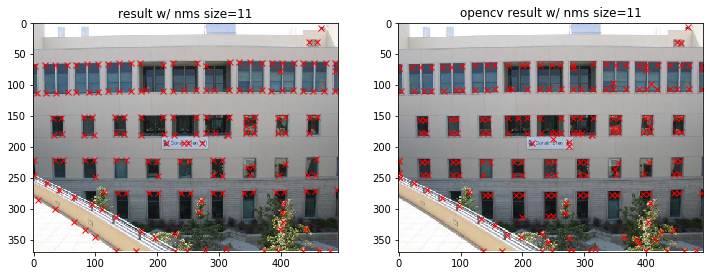

In [10]:
# plotting
plt.figure(num='Harris Corner Detection 1',figsize=(12,12))

plt.subplot(1,2,1)
plt.title(f"result w/ nms size={nms_size}")
plt.imshow(bw_original)
plt.plot(ans[:,0],ans[:,1],'rx')

plt.subplot(1,2,2)
plt.title(f"opencv result w/ nms size={nms_size}")
plt.imshow(bw_original)
plt.plot(sample_ans[:,0],sample_ans[:,1],'rx')
plt.show()

In [11]:
######################################################################
# Task 1.4 & Task 1.5: Image plotting and Comparison
######################################################################

In [12]:
harris_anss = []
sample_harris_anss = []
for i in range(4):
    bw = gray_pics[i]
    Ix = conv2(bw, dx)
    Iy = conv2(bw, dy)
    g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)

    Iy2 = conv2(np.power(Iy, 2), g)
    Ix2 = conv2(np.power(Ix, 2), g)
    Ixy = conv2(Ix * Iy, g)
    
    R = harris_corner(bw, Ix2, Iy2, Ixy,k=k)
    ans= nms_thresholding(R,nms_size=nms_size,d=thresh)


    sample_ans = cv2.cornerHarris(bw,12,3,k)
    sample_ans = nms_thresholding(sample_ans,nms_size=nms_size,d=thresh)

    ans = np.array(ans)
    sample_ans = np.array(sample_ans)
    harris_anss.append(ans)
    sample_harris_anss.append(sample_ans)    

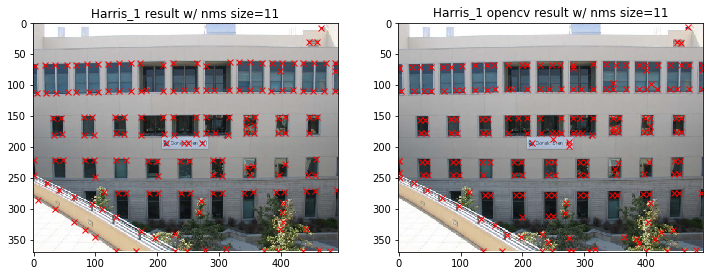

In [13]:
plt.figure(num=f'Harris Corner Detection w/ Comparisons',figsize=(12,12))
ans = harris_anss[0]
sample_ans = sample_harris_anss[0]
plt.subplot(1,2,1)
plt.title(f"Harris_1 result w/ nms size={nms_size}")
plt.imshow(pics[0])
plt.plot(ans[:,0],ans[:,1],'rx')
plt.subplot(1,2,2)
plt.title(f"Harris_1 opencv result w/ nms size={nms_size}")
plt.imshow(pics[0])
plt.plot(sample_ans[:,0],sample_ans[:,1],'rx')
plt.show()

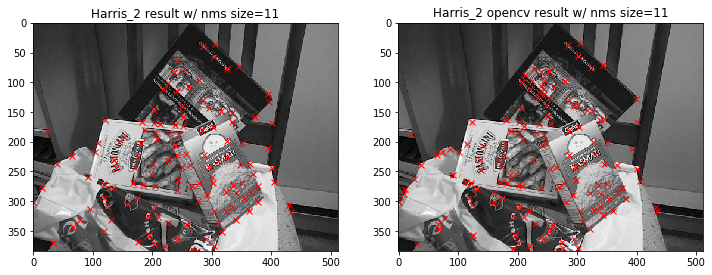

In [14]:
plt.figure(num=f'Harris Corner Detection w/ Comparisons',figsize=(12,12))
ans = harris_anss[1]
sample_ans = sample_harris_anss[1]
plt.subplot(1,2,1)
plt.title(f"Harris_2 result w/ nms size={nms_size}")
plt.imshow(pics[1])
plt.plot(ans[:,0],ans[:,1],'rx')
plt.subplot(1,2,2)
plt.title(f"Harris_2 opencv result w/ nms size={nms_size}")
plt.imshow(pics[1])
plt.plot(sample_ans[:,0],sample_ans[:,1],'rx')
plt.show()

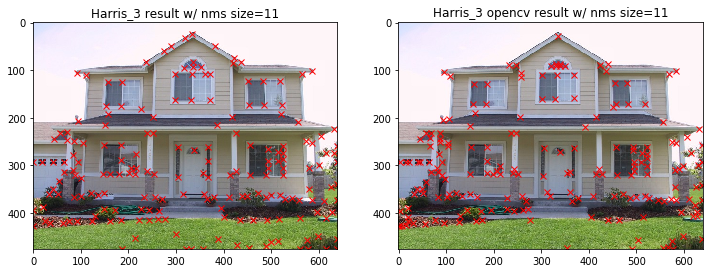

In [15]:
plt.figure(num=f'Harris Corner Detection w/ Comparisons',figsize=(12,12))
ans = harris_anss[2]
sample_ans = sample_harris_anss[2]
plt.subplot(1,2,1)
plt.title(f"Harris_3 result w/ nms size={nms_size}")
plt.imshow(pics[2])
plt.plot(ans[:,0],ans[:,1],'rx')
plt.subplot(1,2,2)
plt.title(f"Harris_3 opencv result w/ nms size={nms_size}")
plt.imshow(pics[2])
plt.plot(sample_ans[:,0],sample_ans[:,1],'rx')
plt.show()

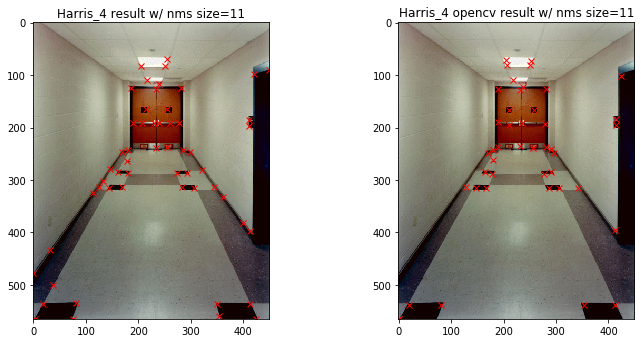

In [16]:
plt.figure(num=f'Harris Corner Detection w/ Comparisons',figsize=(12,12))
ans = harris_anss[3]
sample_ans = sample_harris_anss[3]
plt.subplot(2,2,1)
plt.title(f"Harris_4 result w/ nms size={nms_size}")
plt.imshow(pics[3])
plt.plot(ans[:,0],ans[:,1],'rx')
plt.subplot(2,2,2)
plt.title(f"Harris_4 opencv result w/ nms size={nms_size}")
plt.imshow(pics[3])
plt.plot(sample_ans[:,0],sample_ans[:,1],'rx')

In [17]:
######################################################################
# Task 1.6 Harris-5
######################################################################
bw5_origin = cv2.imread("Harris-5.jpg")
bw5_origin = bw5_origin.transpose(2,0,1)
bw5 = bw5_origin[0]

# bw5_origin = cv2.cvtColor(bw_origin,cv2.COLOR_BGR2RGB)
# bw5 = cv2.cvtColor(bw_origin,cv2.COLOR_BGR2GRAY)

Ix = conv2(bw5, dx)
Iy = conv2(bw5, dy)
g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)

Iy2 = conv2(np.power(Iy, 2), g)
Ix2 = conv2(np.power(Ix, 2), g)
Ixy = conv2(Ix * Iy, g)

R = harris_corner(bw5, Ix2, Iy2, Ixy,k=k)
ans= nms_thresholding(R,nms_size=nms_size,d=thresh)


sample_ans = cv2.cornerHarris(bw5,12,3,k)
sample_ans = nms_thresholding(sample_ans,nms_size=nms_size,d=thresh)

ans = np.array(ans)
sample_ans = np.array(sample_ans)
print(ans.shape)
print(sample_ans.shape)


(0,)
(0,)


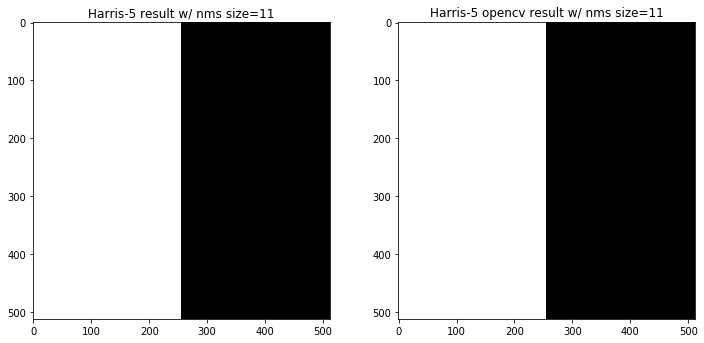

In [18]:
# plotting
plt.figure(num=f'Harris Corner Detection w/ Comparisons',figsize=(12,12))
plt.subplot(2,2,1)
plt.title(f"Harris-5 result w/ nms size={nms_size}")
plt.imshow(bw5,cmap='gray')
if ans.shape[0] > 0:
    plt.plot(ans[:,0],ans[:,1],'rx')
plt.subplot(2,2,2)
plt.title(f"Harris-5 opencv result w/ nms size={nms_size}")
plt.imshow(bw5,cmap='gray')
if sample_ans.shape[0] > 0:
    plt.plot(sample_ans[:,0],sample_ans[:,1],'rx')
plt.show()

In [19]:
######################################################################
# Task 1.7 Harris-6
######################################################################
bw6_origin = cv2.imread("Harris-6.jpg")
bw6_origin = bw6_origin.transpose(2,0,1)
bw6 = bw6_origin[0]

bw6 = cv2.GaussianBlur(bw6,(11,11),5)

Ix = conv2(bw6, dx)
Iy = conv2(bw6, dy)
g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)

Iy2 = conv2(np.power(Iy, 2), g)
Ix2 = conv2(np.power(Ix, 2), g)
Ixy = conv2(Ix * Iy, g)

R = harris_corner(bw6, Ix2, Iy2, Ixy,k=k)
ans= nms_thresholding(R,nms_size=nms_size,d=thresh)


sample_ans = cv2.cornerHarris(bw6,nms_size,3,k)
sample_ans = nms_thresholding(sample_ans,nms_size=nms_size,d=thresh)

ans = np.array(ans)
sample_ans = np.array(sample_ans)
print(ans.shape)
print(sample_ans.shape)

(1, 2)
(1, 2)


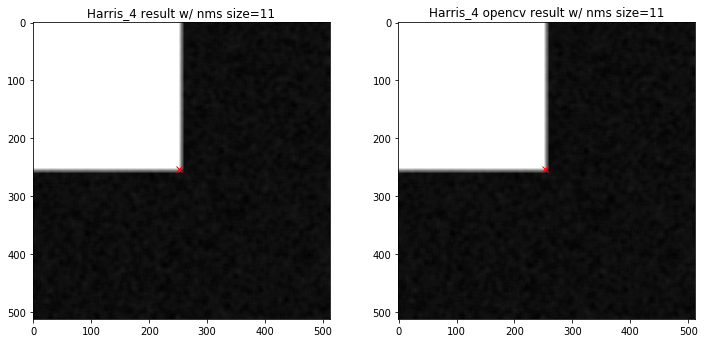

In [20]:
# plotting
plt.figure(num=f'Harris Corner Detection w/ Comparisons',figsize=(12,12))
plt.subplot(2,2,1)
plt.title(f"Harris_4 result w/ nms size={nms_size}")
plt.imshow(bw6,cmap='gray')
plt.plot(ans[:,0],ans[:,1],'rx')
plt.subplot(2,2,2)
plt.title(f"Harris_4 opencv result w/ nms size={nms_size}")
plt.imshow(bw6,cmap='gray')
plt.plot(sample_ans[:,0],sample_ans[:,1],'rx')
plt.show()

In [21]:
######################################################################
# Task 1.7 Harris-6 option B
######################################################################
bw6_2 = bw6_origin[0]
bw6_2 = cv2.medianBlur(bw6_2,3)

Ix = conv2(bw6, dx)
Iy = conv2(bw6, dy)
g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)

Iy2 = conv2(np.power(Iy, 2), g)
Ix2 = conv2(np.power(Ix, 2), g)
Ixy = conv2(Ix * Iy, g)

R = harris_corner(bw6, Ix2, Iy2, Ixy,k=k)
ans= nms_thresholding(R,nms_size=nms_size,d=thresh)


sample_ans = cv2.cornerHarris(bw6,nms_size,3,k)
sample_ans = nms_thresholding(sample_ans,nms_size=nms_size,d=thresh)

ans = np.array(ans)
sample_ans = np.array(sample_ans)
print(ans.shape)
print(sample_ans.shape)

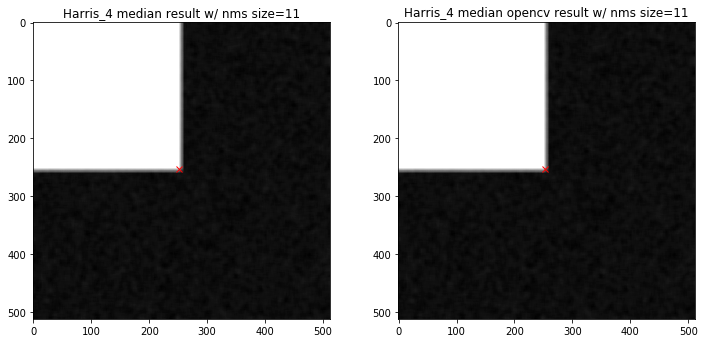

In [23]:
# plotting
plt.figure(num=f'Harris Corner Detection w/ Comparisons',figsize=(12,12))
plt.subplot(2,2,1)
plt.title(f"Harris_4 median result w/ nms size={nms_size}")
plt.imshow(bw6,cmap='gray')
plt.plot(ans[:,0],ans[:,1],'rx')
plt.subplot(2,2,2)
plt.title(f"Harris_4 median opencv result w/ nms size={nms_size}")
plt.imshow(bw6,cmap='gray')
plt.plot(sample_ans[:,0],sample_ans[:,1],'rx')
plt.show()